In [116]:
import sqlite3
# import os.path
import hashlib
import pandas as pd
import numpy as np

name = "disaggregator_results_pie"
name = "Matthijs"

db = './../data/daf06fb3ab69f27bd681a63311722181.db'
#db = './test.db'
#db = './../data/Matthijs/1cb93dd0babab36e9e5efe90a47d7824.db'

db = './../data/Arne/disaggregation.db'

conn = sqlite3.connect(db)

df = pd.read_sql_query("SELECT date,demand_power_L1+demand_power_L2+demand_power_L3 as 'demand' FROM loads;", conn)
conn.close()# close db

df['datetime'] = pd.to_datetime(df['date'])
df.sort_values(by='datetime',ascending=True);


In [8]:
df['dp'] = df['demand'] - df['demand'].shift(1)
df['dp+'] = [0-x if x <=0 else 0 for x in df['dp']]
df['dp-'] = [x if x >=0 else 0 for x in df['dp']]



In [117]:
#do the same again! is this faster?
df['dp'] = df['demand'] - df['demand'].shift(1)
for x in range(1,len(df)):
    df.loc[x,'dp'] = df.loc[x,'demand'] -  df.loc[x-1,'demand']
    if df.loc[x,'dp'] > 0:
        df.loc[x,'dp+'] = df.loc[x,'dp']
        df.loc[x,'dp-'] = 0
    else:
        df.loc[x,'dp-'] = 0-df.loc[x,'dp']
        df.loc[x,'dp+'] = 0



In [118]:
print(df)

                       date  demand            datetime   dp  dp-  dp+
0       2017-09-21 19:10:19   241.0 2017-09-21 19:10:19  NaN  NaN  NaN
1       2017-09-21 19:10:39   241.0 2017-09-21 19:10:39  0.0  0.0  0.0
2       2017-09-21 19:10:58   241.0 2017-09-21 19:10:58  0.0  0.0  0.0
3       2017-09-21 19:11:18   241.0 2017-09-21 19:11:18  0.0  0.0  0.0
4       2017-09-21 19:11:38   240.0 2017-09-21 19:11:38 -1.0  1.0  0.0
5       2017-09-21 19:11:58   240.0 2017-09-21 19:11:58  0.0  0.0  0.0
6       2017-09-21 19:12:18   241.0 2017-09-21 19:12:18  1.0  0.0  1.0
7       2017-09-21 19:12:38   241.0 2017-09-21 19:12:38  0.0  0.0  0.0
8       2017-09-21 19:12:58   240.0 2017-09-21 19:12:58 -1.0  1.0  0.0
9       2017-09-21 19:13:17   239.0 2017-09-21 19:13:17 -1.0  1.0  0.0
10      2017-09-21 19:13:37   240.0 2017-09-21 19:13:37  1.0  0.0  1.0
11      2017-09-21 19:13:57   241.0 2017-09-21 19:13:57  1.0  0.0  1.0
12      2017-09-21 19:14:17   241.0 2017-09-21 19:14:17  0.0  0.0  0.0
13    

In [10]:
# add user defined loads (that are always on)
user_loads = {'modem':10,'rPi':4}
baseload = 0
for user_load in user_loads:
    df.loc[:,user_load]  = user_loads[user_load]
    baseload = baseload + user_loads[user_load]
#     df.loc[:,] = np.array([df['demand'].min()] * len(df))


In [11]:
# find baseload and determine remaining unkwown profile
df.loc[:,'baseload'] = np.array([df['demand'].min()-baseload] * len(df)) #sets baseload colum to min value minus users defined loads
df.loc[:,'unknown'] = df.loc[:,'demand'] - df.loc[:,'baseload']-baseload #calculate remaining load = demand - baseload(s)


In [12]:
#function left_round round number left of the decimal point. (NEEDS A FIX)
def left_round(number,precision=2):
    rem = number

    d = len(str(number))
    while(round(rem,d) == round(number,d)):
        rem = round(number,d-precision)
        d = d -1
        
    i = 0
    while(rem > 10**precision):
        rem = round(rem / 10,0)
        i = i +1
#         print(rem*(10**i))
        if i > 100:
            break
    return rem*(10**i)

left_round(00.00034564,3)

left_round(122431234.00034564,3)

# left_round(123456)

122000000.0

# find square loads and save them to a dict

In [13]:
# create a dict to safe found devices/loads
loads = dict()

for x in range(1,len(df)):
    #filter for dP+ with minimim power
    if df.loc[x,'dp+'] > 100:
        print(' ') #new line in output
        print ('start dp>100:',df.loc[x,'datetime'],'start P:',df.loc[x-1,'unknown'],', dP+:' ,df.loc[x,'dp+'])
        
        #look forwar in time to see how long load remains on
        for y in range(x+1,len(df)):
            #find dP- of same/simulair size 
            if df.loc[y,'dp-'] > 0.9 *df.loc[x,'dp+'] and df.loc[y,'dp-'] < 1.1 *df.loc[x,'dp+']:
                print ('stop dP-:',df.loc[y,'datetime'],'dP-:' ,df.loc[y,'dp-'])
                break
            # check if load does not drop below start power (this means is must have been turned of or other loads were already present (=ON))    
            if df.loc[y,'unknown'] <= df.loc[x-1,'unknown']:
                print ('stop demand:',df.loc[x,'datetime'] ,df.loc[y,'unknown'], ' <= ',df.loc[x-1,'unknown'])
                break
        
        print(x,y,(df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean())
        
        # calculate key parameters
        mean = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean()
        max = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).max()
        min = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).min()
        std = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).std()
        time = pd.Timedelta(pd.to_datetime(df['datetime'][y])-pd.to_datetime(df['datetime'][x]))
        noise = df.loc[x+1:y-1,'dp'].abs().mean()
        
        print('mean load:',mean)
        print('max load:',max)
        print('std load:',std)
        print('noise:',noise)
        print('time past:',time)


        print('found profile from ',df.loc[x-1,'datetime'],'to',df.loc[y,'datetime'])
        profile = list(df.loc[x-1:y,'unknown']-df.loc[x-1,'unknown'])
        print(profile)
        
        
#         plt.plot(range(x,y),profile)
#         plt.title('A simple chirp')
#         plt.show()
#         break
        try:
            #drop loads which do not have a square looking profile.
            if (std/mean > 0.1):
                print('dropped because of large std:',std/mean)
                continue

            #drop loads which do not have odd start compared to mean
            if( abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'] > 0.2):    
                print('dropped because large difference between mean and start dp+:',abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'])
                continue
        except:
            print('Something went wrong in analysing found load, dropping ....')
            continue
#         print('hist:',df.hist(bins=10))
        
        # save this load to the distionairy (group by 'fingerprint')
        fingerprint = str(int(round(mean,-2)))+'_'#+str(int(left_round(df.loc[x,'dp+'],2)))
        temp = {'index':{'start':x,'stop':y},'time':time,'mean':mean,'max':max,'profile':profile}
        try:
            loads[fingerprint][len(loads[fingerprint])] = temp
        except:
            loads[fingerprint] = {0:temp}
            df[fingerprint] = 0 #add new colum to the dataframe before inserting found loads (only on first occurance!)
        
        df.loc[x:y-1,fingerprint] = profile[1:-1]
        df.loc[x:y-1,'unknown'] = df.loc[x:y-1,'unknown'] - profile[1:-1]
        print('Saved with fingerprint:',fingerprint)



 
start dp>100: 2017-12-14 22:40:08 start P: 103.0 , dP+: 103.0
stop demand: 2017-12-14 22:40:08 102.0  <=  103.0
1819 1933 74.16666666666667
mean load: 74.16666666666667
max load: 105.0
std load: 6.445025064543645
noise: 0.5398230088495575
time past: 0 days 00:10:27
found profile from  2017-12-14 22:39:58 to 2017-12-14 22:50:35
[0.0, 103.0, 103.0, 105.0, 105.0, 103.0, 77.0, 75.0, 75.0, 73.0, 73.0, 71.0, 71.0, 71.0, 71.0, 72.0, 72.0, 72.0, 72.0, 73.0, 73.0, 73.0, 73.0, 74.0, 74.0, 74.0, 75.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 73.0, 73.0, 74.0, 74.0, 73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 72.0, 72.0, 73.0, 73.0, 73.0, 73.0, 73.0, 73.0, 72.0, 72.0, 73.0, 73.0, 73.0, 72.0, 73.0, 73.0, 73.0, 73.0, 72.0, 72.0, 73.0, 73.0, 73.0, 73.0, 72.0, 72.0, 73.0, 73.0, 72.0, 72.0, 73.0, 73.0, 72.0, 73.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 73.0, 73.0, 73.0, 73.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0

Saved with fingerprint: 700_
 
start dp>100: 2017-12-15 08:07:12 start P: 241.0 , dP+: 1261.0
stop dP-: 2017-12-15 08:07:33 dP-: 1157.0
7998 8001 1263.0
mean load: 1263.0
max load: 1264.0
std load: 1.7320508075688772
noise: 1.5
time past: 0 days 00:00:21
found profile from  2017-12-15 08:07:11 to 2017-12-15 08:07:33
[0.0, 1261.0, 1264.0, 1264.0, 107.0]
Saved with fingerprint: 1300_
 
start dp>100: 2017-12-15 08:07:55 start P: 242.0 , dP+: 1055.0
stop dP-: 2017-12-15 08:08:06 dP-: 1055.0
8005 8007 1055.0
mean load: 1055.0
max load: 1055.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:11
found profile from  2017-12-15 08:07:45 to 2017-12-15 08:08:06
[0.0, 1055.0, 1055.0, 0.0]
Saved with fingerprint: 1100_
 
start dp>100: 2017-12-15 08:10:07 start P: 240.0 , dP+: 194.0
stop demand: 2017-12-15 08:10:07 228.0  <=  240.0
8029 8038 970.1111111111111
mean load: 970.1111111111111
max load: 1314.0
std load: 511.16886750966273
noise: 240.375
time past: 0 days 00:00:45
found profile from  2017-

Saved with fingerprint: 1800_
 
start dp>100: 2017-12-15 12:47:13 start P: 75.0 , dP+: 741.0
stop demand: 2017-12-15 12:47:13 2.0  <=  75.0
11014 11018 631.5
mean load: 631.5
max load: 741.0
std load: 126.43970895252804
noise: 73.0
time past: 0 days 00:00:22
found profile from  2017-12-15 12:47:07 to 2017-12-15 12:47:35
[0.0, 741.0, 741.0, 522.0, 522.0, -73.0]
dropped because of large std: 0.20022123349568968
 
start dp>100: 2017-12-15 12:47:57 start P: 2.0 , dP+: 433.0
stop dP-: 2017-12-15 12:48:08 dP-: 435.0
11022 11024 433.0
mean load: 433.0
max load: 433.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:11
found profile from  2017-12-15 12:47:51 to 2017-12-15 12:48:08
[0.0, 433.0, 433.0, -2.0]
Saved with fingerprint: 400_
 
start dp>100: 2017-12-15 12:48:24 start P: 0.0 , dP+: 657.0
stop demand: 2017-12-15 12:48:24 0.0  <=  0.0
11027 11031 581.5
mean load: 581.5
max load: 657.0
std load: 87.17989064763348
noise: 50.333333333333336
time past: 0 days 00:00:22
found profile from  201

Saved with fingerprint: 1900_
 
start dp>100: 2017-12-15 16:16:57 start P: 135.0 , dP+: 143.0
stop dP-: 2017-12-15 16:43:54 dP-: 143.0
13283 13577 670.4727891156463
mean load: 670.4727891156463
max load: 3747.0
std load: 900.7829383305478
noise: 29.017064846416382
time past: 0 days 00:26:57
found profile from  2017-12-15 16:16:51 to 2017-12-15 16:43:54
[0.0, 143.0, 143.0, 148.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 140.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 133.0, 133.0, 131.0, 131.0, 131.0, 132.0, 132.0, 132.0, 132.0, 133.0, 133.0, 132.0, 132.0, 133.0, 133.0, 133.0, 129.0, 129.0, 125.0, 125.0, 125.0, 125.0, 124.0, 124.0, 124.0, 124.0, 124.0, 217.0, 217.0, 196.0, 196.0, 198.0, 198.0, 199.0, 199.0, 199.0, 198.0, 198.0, 198.0, 198.0, 200.0, 200.0, 200.0, 200.0, 201.0, 200.0, 200.0, 200.0, 200.0, 199.0, 199.0, 199.0, 199.0, 199.0, 199.0, 199.0, 200.0, 200.0, 199.0, 199.0, 199.0, 199.0, 200.0, 200.0, 194.0, 185.0, 185.0, 185.0, 185.0, 185.0, 185.0, 185.0, 185.0, 18

start dp>100: 2017-12-15 16:50:35 start P: 1482.0 , dP+: 126.0
stop dP-: 2017-12-15 16:51:03 dP-: 133.0
13650 13655 162.2
mean load: 162.2
max load: 188.0
std load: 33.108911187171344
noise: 16.75
time past: 0 days 00:00:28
found profile from  2017-12-15 16:50:30 to 2017-12-15 16:51:03
[0.0, 126.0, 126.0, 188.0, 188.0, 183.0, 50.0]
dropped because of large std: 0.20412399005654344
 
start dp>100: 2017-12-15 16:51:58 start P: 789.0 , dP+: 102.0
stop dP-: 2017-12-15 16:52:25 dP-: 102.0
13665 13670 141.2
mean load: 141.2
max load: 159.0
std load: 23.32809465001375
noise: 18.25
time past: 0 days 00:00:27
found profile from  2017-12-15 16:51:52 to 2017-12-15 16:52:25
[0.0, 102.0, 159.0, 159.0, 143.0, 143.0, 41.0]
dropped because of large std: 0.16521313491511155
 
start dp>100: 2017-12-15 16:53:53 start P: 754.0 , dP+: 108.0
stop dP-: 2017-12-15 16:54:26 dP-: 103.0
13686 13692 147.66666666666666
mean load: 147.66666666666666
max load: 184.0
std load: 34.086165326517246
noise: 21.8
time past

Saved with fingerprint: 1900_
 
start dp>100: 2017-12-16 07:09:49 start P: 208.0 , dP+: 123.0
stop dP-: 2017-12-16 07:10:00 dP-: 123.0
23020 23022 123.0
mean load: 123.0
max load: 123.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:11
found profile from  2017-12-16 07:09:42 to 2017-12-16 07:10:00
[0.0, 123.0, 123.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2017-12-16 07:10:04 start P: 208.0 , dP+: 101.0
stop dP-: 2017-12-16 07:10:15 dP-: 101.0
23023 23025 101.0
mean load: 101.0
max load: 101.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:11
found profile from  2017-12-16 07:10:00 to 2017-12-16 07:10:15
[0.0, 101.0, 101.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2017-12-16 07:10:37 start P: 209.0 , dP+: 108.0
stop dP-: 2017-12-16 07:11:50 dP-: 100.0
23029 23042 1625.2307692307693
mean load: 1625.2307692307693
max load: 2107.0
std load: 875.6045676984326
noise: 183.41666666666666
time past: 0 days 00:01:13
found profile from  2017-12-16 07:10:33 to 2017-12-16 07

found profile from  2017-12-16 07:32:37 to 2017-12-16 07:32:48
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-16 07:33:17 start P: 290.0 , dP+: 130.0
stop demand: 2017-12-16 07:33:17 290.0  <=  290.0
23276 23277 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:04
found profile from  2017-12-16 07:33:10 to 2017-12-16 07:33:21
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-16 07:34:34 start P: 290.0 , dP+: 173.0
stop demand: 2017-12-16 07:34:34 290.0  <=  290.0
23290 23291 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:04
found profile from  2017-12-16 07:34:27 to 2017-12-16 07:34:38
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-16 07:35:55 start P: 290.0 , dP+: 145.0
stop demand: 2017-12-16 07:35:55 290.0  <=  290.0
23305 23306 0.0
mean load: 0.0
max load: 0.0
st

noise: 16.0
time past: 0 days 00:02:16
found profile from  2017-12-16 08:04:42 to 2017-12-16 08:07:05
[0.0, 113.0, 113.0, 107.0, 78.0, 78.0, 147.0, 147.0, 190.0, 190.0, 174.0, 181.0, 181.0, 192.0, 192.0, 211.0, 211.0, 213.0, 213.0, 177.0, 177.0, 240.0, 240.0, 166.0, 175.0, 175.0, -35.0]
dropped because of large std: 0.2597011600837833
 
start dp>100: 2017-12-16 08:10:30 start P: 29.0 , dP+: 209.0
stop dP-: 2017-12-16 08:11:14 dP-: 208.0
23682 23690 155.125
mean load: 155.125
max load: 227.0
std load: 92.57959895601807
noise: 59.285714285714285
time past: 0 days 00:00:44
found profile from  2017-12-16 08:10:23 to 2017-12-16 08:11:14
[0.0, 209.0, 165.0, 165.0, 11.0, 11.0, 227.0, 227.0, 226.0, 18.0]
dropped because of large std: 0.5968064396842422
 
start dp>100: 2017-12-16 08:10:56 start P: 40.0 , dP+: 216.0
stop dP-: 2017-12-16 08:11:14 dP-: 208.0
23687 23690 215.66666666666666
mean load: 215.66666666666666
max load: 216.0
std load: 0.5773502691896258
noise: 0.5
time past: 0 days 00:00:

mean load: 101.08333333333333
max load: 120.0
std load: 25.321418649519668
noise: 13.727272727272727
time past: 0 days 00:01:06
found profile from  2017-12-16 15:22:53 to 2017-12-16 15:24:06
[0.0, 109.0, 109.0, 118.0, 111.0, 111.0, 105.0, 105.0, 48.0, 48.0, 109.0, 120.0, 120.0, -3.0]
dropped because of large std: 0.2505004318171773
 
start dp>100: 2017-12-16 15:24:17 start P: 168.0 , dP+: 117.0
stop dP-: 2017-12-16 15:25:27 dP-: 108.0
28414 28427 108.07692307692308
mean load: 108.07692307692308
max load: 136.0
std load: 16.755404791994426
noise: 11.666666666666666
time past: 0 days 00:01:10
found profile from  2017-12-16 15:24:10 to 2017-12-16 15:25:27
[0.0, 117.0, 117.0, 97.0, 97.0, 136.0, 136.0, 83.0, 83.0, 97.0, 110.0, 110.0, 111.0, 111.0, 3.0]
dropped because of large std: 0.1550322151572438
 
start dp>100: 2017-12-16 15:26:55 start P: 179.0 , dP+: 215.0
stop demand: 2017-12-16 15:26:55 149.0  <=  179.0
28443 28518 114.21333333333334
mean load: 114.21333333333334
max load: 215.0
st

start dp>100: 2017-12-16 15:53:59 start P: 198.0 , dP+: 186.0
stop dP-: 2017-12-16 17:11:25 dP-: 188.0
28738 29583 607.8532544378699
mean load: 607.8532544378699
max load: 3740.0
std load: 806.8341045587304
noise: 26.240521327014218
time past: 0 days 01:17:26
found profile from  2017-12-16 15:53:52 to 2017-12-16 17:11:25
[0.0, 186.0, 186.0, 108.0, 108.0, 217.0, 149.0, 149.0, 40.0, 40.0, 27.0, 27.0, 8.0, 5.0, 5.0, 26.0, 26.0, 17.0, 17.0, 74.0, 74.0, 29.0, 29.0, 13.0, 13.0, 53.0, 43.0, 43.0, 34.0, 34.0, 145.0, 145.0, 177.0, 236.0, 236.0, 209.0, 209.0, 230.0, 230.0, 197.0, 197.0, 267.0, 267.0, 222.0, 222.0, 217.0, 186.0, 186.0, 182.0, 182.0, 179.0, 179.0, 208.0, 228.0, 228.0, 224.0, 224.0, 230.0, 230.0, 281.0, 281.0, 273.0, 273.0, 302.0, 302.0, 333.0, 357.0, 357.0, 326.0, 326.0, 336.0, 336.0, 359.0, 402.0, 402.0, 431.0, 431.0, 445.0, 445.0, 449.0, 449.0, 476.0, 476.0, 443.0, 443.0, 482.0, 459.0, 459.0, 473.0, 473.0, 484.0, 484.0, 512.0, 530.0, 530.0, 556.0, 556.0, 582.0, 582.0, 601.0, 601

start dp>100: 2017-12-16 16:49:21 start P: 335.0 , dP+: 115.0
stop dP-: 2017-12-16 16:49:58 dP-: 110.0
29342 29349 115.85714285714286
mean load: 115.85714285714286
max load: 132.0
std load: 13.49603116263656
noise: 8.166666666666666
time past: 0 days 00:00:37
found profile from  2017-12-16 16:49:14 to 2017-12-16 16:49:58
[0.0, 115.0, 99.0, 99.0, 117.0, 117.0, 132.0, 132.0, 22.0]
dropped because of large std: 0.11648855504125268
 
start dp>100: 2017-12-16 16:50:38 start P: 335.0 , dP+: 107.0
stop dP-: 2017-12-16 16:51:15 dP-: 102.0
29356 29363 114.14285714285714
mean load: 114.14285714285714
max load: 128.0
std load: 10.47900395121234
noise: 8.0
time past: 0 days 00:00:37
found profile from  2017-12-16 16:50:31 to 2017-12-16 16:51:15
[0.0, 107.0, 107.0, 114.0, 114.0, 128.0, 128.0, 101.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2017-12-16 16:51:26 start P: 334.0 , dP+: 136.0
stop dP-: 2017-12-16 16:51:48 dP-: 128.0
29365 29369 132.0
mean load: 132.0
max load: 136.0
std load: 4

found profile from  2017-12-16 17:23:20 to 2017-12-16 17:23:49
[0.0, 187.0, 187.0, 145.0, 145.0, 0.0]
dropped because of large std: 0.14607657413231495
 
start dp>100: 2017-12-16 17:24:00 start P: 360.0 , dP+: 184.0
stop dP-: 2017-12-16 17:24:15 dP-: 188.0
29720 29723 185.33333333333334
mean load: 185.33333333333334
max load: 188.0
std load: 2.3094010767585034
noise: 2.0
time past: 0 days 00:00:15
found profile from  2017-12-16 17:23:53 to 2017-12-16 17:24:15
[0.0, 184.0, 184.0, 188.0, 0.0]
Saved with fingerprint: 200_
 
start dp>100: 2017-12-16 17:24:26 start P: 360.0 , dP+: 188.0
stop dP-: 2017-12-16 17:24:48 dP-: 195.0
29725 29729 191.5
mean load: 191.5
max load: 195.0
std load: 4.041451884327381
noise: 2.3333333333333335
time past: 0 days 00:00:22
found profile from  2017-12-16 17:24:22 to 2017-12-16 17:24:48
[0.0, 188.0, 188.0, 195.0, 195.0, 0.0]
Saved with fingerprint: 200_
 
start dp>100: 2017-12-16 17:24:55 start P: 360.0 , dP+: 156.0
stop demand: 2017-12-16 17:24:55 342.0  <= 

39320 40444 542.479537366548
mean load: 542.479537366548
max load: 2226.0
std load: 807.0383178138026
noise: 21.081032947462155
time past: 0 days 01:43:02
found profile from  2017-12-17 08:04:01 to 2017-12-17 09:47:08
[0.0, 139.0, 139.0, 156.0, 156.0, 161.0, 161.0, 190.0, 190.0, 141.0, 135.0, 135.0, 106.0, 106.0, 108.0, 108.0, 142.0, 142.0, 118.0, 118.0, 117.0, 121.0, 121.0, 123.0, 123.0, 109.0, 109.0, 137.0, 137.0, 121.0, 141.0, 141.0, 111.0, 111.0, 2065.0, 2065.0, 2045.0, 2045.0, 2044.0, 2044.0, 2039.0, 2036.0, 2036.0, 2047.0, 2047.0, 2040.0, 2040.0, 2054.0, 2054.0, 2059.0, 2048.0, 2048.0, 2105.0, 2105.0, 2026.0, 2026.0, 2122.0, 2122.0, 2182.0, 2182.0, 2221.0, 2174.0, 2174.0, 2184.0, 2184.0, 2195.0, 2195.0, 2222.0, 2222.0, 2173.0, 2160.0, 2160.0, 2168.0, 2168.0, 2160.0, 2160.0, 2172.0, 2172.0, 2208.0, 2208.0, 2215.0, 312.0, 312.0, 289.0, 289.0, 310.0, 310.0, 288.0, 288.0, 301.0, 291.0, 291.0, 306.0, 306.0, 110.0, 110.0, 206.0, 206.0, 203.0, 203.0, 189.0, 204.0, 204.0, 225.0, 225.0, 1

start dp>100: 2017-12-17 09:33:51 start P: 116.0 , dP+: 104.0
stop demand: 2017-12-17 09:33:51 116.0  <=  116.0
40299 40300 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:05
found profile from  2017-12-17 09:33:45 to 2017-12-17 09:33:56
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-17 09:39:10 start P: 116.0 , dP+: 127.0
stop demand: 2017-12-17 09:39:10 116.0  <=  116.0
40357 40358 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:05
found profile from  2017-12-17 09:39:04 to 2017-12-17 09:39:15
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-17 09:41:49 start P: 116.0 , dP+: 113.0
stop demand: 2017-12-17 09:41:49 116.0  <=  116.0
40386 40387 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-17 09:41:44 to 2017-12-17 09:41:55
[0.0, 0.0, 0.0]
Something we

std load: 93.60913784169784
noise: 4.216216216216216
time past: 0 days 00:13:39
found profile from  2017-12-17 16:02:25 to 2017-12-17 16:16:11
[0.0, 246.0, 244.0, 244.0, 242.0, 242.0, 241.0, 241.0, 243.0, 243.0, 253.0, 252.0, 252.0, 257.0, 257.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 257.0, 258.0, 258.0, 258.0, 258.0, 404.0, 404.0, 408.0, 408.0, 408.0, 407.0, 407.0, 406.0, 406.0, 406.0, 406.0, 400.0, 400.0, 409.0, 409.0, 410.0, 402.0, 402.0, 399.0, 399.0, 398.0, 398.0, 396.0, 396.0, 483.0, 476.0, 476.0, 475.0, 475.0, 473.0, 473.0, 469.0, 469.0, 470.0, 470.0, 470.0, 470.0, 470.0, 479.0, 479.0, 480.0, 480.0, 480.0, 480.0, 480.0, 480.0, 480.0, 481.0, 481.0, 481.0, 481.0, 482.0, 482.0, 502.0, 502.0, 507.0, 508.0, 508.0, 484.0, 484.0, 483.0, 483.0, 481.0, 481.0, 536.0, 537.0, 537.0, 537.0, 537.0, 535.0, 535.0, 526.0, 526.0, 522.0, 522.0, 523.0, 524.0, 524.0, 516.0, 516.0, 509.0, 509.0, 509.0, 509.0, 517.0, 526.0, 526.0, 527.0, 527.0, 475.0, 475.0, 477.0, 477.0, 480.0, 480.0, 480.0, 504.

mean load: 749.4545454545455
max load: 1222.0
std load: 449.8216010011888
noise: 153.2
time past: 0 days 00:01:00
found profile from  2017-12-17 16:40:34 to 2017-12-17 16:41:40
[0.0, 262.0, 262.0, 135.0, 135.0, 1066.0, 907.0, 907.0, 1063.0, 1063.0, 1222.0, 1222.0, -97.0]
dropped because of large std: 0.600198642772086
 
start dp>100: 2017-12-17 16:41:02 start P: 2375.0 , dP+: 931.0
stop demand: 2017-12-17 16:41:02 2143.0  <=  2375.0
44959 44966 929.2857142857143
mean load: 929.2857142857143
max load: 1087.0
std load: 128.60237722752808
noise: 79.0
time past: 0 days 00:00:38
found profile from  2017-12-17 16:40:56 to 2017-12-17 16:41:40
[0.0, 931.0, 772.0, 772.0, 928.0, 928.0, 1087.0, 1087.0, -232.0]
dropped because of large std: 0.13838841515644834
 
start dp>100: 2017-12-17 16:41:18 start P: 3147.0 , dP+: 156.0
stop demand: 2017-12-17 16:41:18 2143.0  <=  3147.0
44962 44966 235.5
mean load: 235.5
max load: 315.0
std load: 91.7986928011505
noise: 53.0
time past: 0 days 00:00:22
found p

start dp>100: 2017-12-17 16:48:27 start P: 1105.0 , dP+: 1239.0
stop demand: 2017-12-17 16:48:27 805.0  <=  1105.0
45040 45051 889.7272727272727
mean load: 889.7272727272727
max load: 1239.0
std load: 297.88591470866527
noise: 175.7
time past: 0 days 00:01:01
found profile from  2017-12-17 16:48:22 to 2017-12-17 16:49:28
[0.0, 1239.0, 1239.0, 1091.0, 1091.0, 955.0, 955.0, 411.0, 411.0, 1015.0, 690.0, 690.0, -300.0]
dropped because of large std: 0.3348058712368773
 
start dp>100: 2017-12-17 16:49:11 start P: 1516.0 , dP+: 604.0
stop demand: 2017-12-17 16:49:11 805.0  <=  1516.0
45048 45051 387.3333333333333
mean load: 387.3333333333333
max load: 604.0
std load: 187.63883748662838
noise: 162.5
time past: 0 days 00:00:17
found profile from  2017-12-17 16:49:06 to 2017-12-17 16:49:28
[0.0, 604.0, 279.0, 279.0, -711.0]
dropped because of large std: 0.48443761829594245
 
start dp>100: 2017-12-17 16:49:39 start P: 805.0 , dP+: 288.0
stop demand: 2017-12-17 16:49:39 773.0  <=  805.0
45053 4506

mean load: 1227.7945205479452
max load: 1546.0
std load: 273.53330890527707
noise: 97.54166666666667
time past: 0 days 00:06:41
found profile from  2017-12-17 16:57:04 to 2017-12-17 17:03:51
[0.0, 1349.0, 1349.0, 1283.0, 1283.0, 1125.0, 1000.0, 1000.0, 54.0, 54.0, 1546.0, 1546.0, 1496.0, 1496.0, 1349.0, 1265.0, 1265.0, 1261.0, 1261.0, 1080.0, 1080.0, 1075.0, 1075.0, 1049.0, 1049.0, 1330.0, 1337.0, 1337.0, 1399.0, 1399.0, 1409.0, 1409.0, 1395.0, 1395.0, 1033.0, 950.0, 950.0, 948.0, 948.0, 1471.0, 1471.0, 1478.0, 1478.0, 1344.0, 1344.0, 1363.0, 1393.0, 1393.0, 1089.0, 1089.0, 948.0, 948.0, 1081.0, 1081.0, 1341.0, 1456.0, 1456.0, 1458.0, 1458.0, 1377.0, 1377.0, 1254.0, 1254.0, 952.0, 952.0, 948.0, 1073.0, 1073.0, 1471.0, 1471.0, 1361.0, 1361.0, 1468.0, 1468.0, 11.0]
dropped because of large std: 0.22278427239046766
 
start dp>100: 2017-12-17 16:57:59 start P: 723.0 , dP+: 1492.0
stop dP-: 2017-12-17 17:03:51 dP-: 1457.0
45144 45208 1213.6875
mean load: 1213.6875
max load: 1492.0
std load:

time past: 0 days 00:11:11
found profile from  2017-12-17 21:02:33 to 2017-12-17 21:13:50
[0.0, 807.0, 807.0, 85.0, 85.0, 84.0, 84.0, 82.0, 55.0, 55.0, 54.0, 54.0, 51.0, 51.0, 54.0, 54.0, 78.0, 63.0, 63.0, 91.0, 91.0, 629.0, 629.0, 93.0, 93.0, 327.0, 327.0, 92.0, 364.0, 364.0, 91.0, 91.0, 71.0, 71.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 35.0, 35.0, 35.0, 34.0, 34.0, 39.0, 39.0, 39.0, 39.0, 49.0, 49.0, 75.0, 75.0, 83.0, 74.0, 74.0, 84.0, 84.0, 101.0, 101.0, 92.0, 92.0, 92.0, 98.0, 98.0, 101.0, 101.0, 102.0, 102.0, 101.0, 101.0, 99.0, 99.0, 99.0, 101.0, 101.0, 101.0, 101.0, 101.0, 101.0, 83.0, 83.0, 57.0, 60.0, 60.0, 84.0, 84.0, 83.0, 83.0, 57.0, 57.0, 60.0, 60.0, 61.0, 62.0, 62.0, 63.0, 63.0, 59.0, 59.0, 67.0, 67.0, 66.0, 64.0, 64.0, 59.0, 59.0, 62.0, 62.0, -16.0]
dropped because of large std: 1.3224017641722894
 
start dp>100: 2017-12-17 21:04:29 start P: 222.0 , dP+: 538.0
stop dP-: 2017-12-17 21:04:40 

noise: 0.0
time past: 0 days 00:00:11
found profile from  2017-12-18 06:52:05 to 2017-12-18 06:52:21
[0.0, 701.0, 701.0, 60.0]
Saved with fingerprint: 700_
 
start dp>100: 2017-12-18 07:36:21 start P: 43.0 , dP+: 162.0
stop demand: 2017-12-18 07:36:21 43.0  <=  43.0
54726 54860 86.03731343283582
mean load: 86.03731343283582
max load: 166.0
std load: 50.13821598843067
noise: 2.744360902255639
time past: 0 days 00:12:17
found profile from  2017-12-18 07:36:16 to 2017-12-18 07:48:38
[0.0, 162.0, 162.0, 83.0, 81.0, 81.0, 79.0, 79.0, 79.0, 79.0, 77.0, 77.0, 75.0, 75.0, 75.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 75.0, 75.0, 75.0, 76.0, 76.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 166.0, 166.0, 154.0, 154.0, 155.0, 155.0, 154.0, 154.0, 155.0, 155.0, 155.0, 155.0, 155.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 156.0, 154.0, 154.0, 138.0, 138.0, 137.0, 137.0, 137.0, 138.0, 138.0, 138.

start dp>100: 2017-12-18 18:07:41 start P: 236.0 , dP+: 138.0
stop demand: 2017-12-18 18:07:41 210.0  <=  236.0
61613 63957 160.8080204778157
mean load: 160.8080204778157
max load: 2054.0
std load: 223.9662567654616
noise: 4.242424242424242
time past: 0 days 03:34:52
found profile from  2017-12-18 18:07:35 to 2017-12-18 21:42:33
[0.0, 138.0, 138.0, 137.0, 137.0, 136.0, 136.0, 161.0, 154.0, 154.0, 152.0, 152.0, 153.0, 153.0, 153.0, 153.0, 81.0, 62.0, 62.0, 49.0, 49.0, 49.0, 49.0, 58.0, 58.0, 58.0, 58.0, 56.0, 53.0, 53.0, 50.0, 50.0, 48.0, 48.0, 45.0, 45.0, 42.0, 43.0, 43.0, 42.0, 42.0, 41.0, 41.0, 41.0, 41.0, 44.0, 44.0, 43.0, 42.0, 42.0, 42.0, 42.0, 43.0, 43.0, 44.0, 44.0, 43.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 74.0, 75.0, 75.0, 74.0, 74.0, 92.0, 92.0, 88.0, 87.0, 87.0, 86.0, 86.0, 88.0, 88.0, 88.0, 88.0, 87.0, 89.0, 89.0, 88.0, 88.0, 89.0, 89.0, 89.0, 89.0, 88.0, 88.0, 88.0, 89.0, 

Saved with fingerprint: 900_
 
start dp>100: 2017-12-19 06:12:30 start P: 187.0 , dP+: 1890.0
stop dP-: 2017-12-19 06:17:00 dP-: 1866.0
69520 69569 1879.0
mean load: 1879.0
max load: 1890.0
std load: 5.986094998689324
noise: 2.25
time past: 0 days 00:04:30
found profile from  2017-12-19 06:12:25 to 2017-12-19 06:17:00
[0.0, 1890.0, 1890.0, 1874.0, 1874.0, 1870.0, 1870.0, 1877.0, 1877.0, 1866.0, 1870.0, 1870.0, 1883.0, 1883.0, 1881.0, 1881.0, 1877.0, 1877.0, 1874.0, 1874.0, 1887.0, 1887.0, 1887.0, 1887.0, 1887.0, 1885.0, 1885.0, 1884.0, 1884.0, 1884.0, 1883.0, 1883.0, 1884.0, 1884.0, 1880.0, 1880.0, 1881.0, 1881.0, 1877.0, 1877.0, 1874.0, 1874.0, 1874.0, 1871.0, 1871.0, 1874.0, 1874.0, 1879.0, 1879.0, 1876.0, 10.0]
Saved with fingerprint: 1900_
 
start dp>100: 2017-12-19 06:40:50 start P: 271.0 , dP+: 110.0
stop demand: 2017-12-19 06:40:50 239.0  <=  271.0
69829 69831 110.0
mean load: 110.0
max load: 110.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:11
found profile from  2017-12-1

noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 06:54:46 to 2017-12-19 06:54:57
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 06:55:13 start P: 219.0 , dP+: 113.0
stop demand: 2017-12-19 06:55:13 219.0  <=  219.0
69986 69987 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 06:55:08 to 2017-12-19 06:55:19
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 06:56:25 start P: 219.0 , dP+: 112.0
stop dP-: 2017-12-19 06:56:30 dP-: 116.0
69999 70000 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:05
found profile from  2017-12-19 06:56:19 to 2017-12-19 06:56:30
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 06:57:31 start P: 219.0 , dP+: 105.0
stop demand: 2017-12-19 06:57:31 219.0  <=  219.0
70011 70012 0.0
me

70455 70456 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:05
found profile from  2017-12-19 07:38:07 to 2017-12-19 07:38:18
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 07:39:02 start P: 219.0 , dP+: 125.0
stop demand: 2017-12-19 07:39:02 219.0  <=  219.0
70464 70465 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 07:38:57 to 2017-12-19 07:39:08
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 07:39:24 start P: 219.0 , dP+: 276.0
stop dP-: 2017-12-19 07:39:30 dP-: 280.0
70468 70469 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 07:39:19 to 2017-12-19 07:39:30
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 07:39:52 start P: 219.0 , dP+: 121.0
stop dema

start dp>100: 2017-12-19 07:59:01 start P: 219.0 , dP+: 385.0
stop demand: 2017-12-19 07:59:01 219.0  <=  219.0
70682 70683 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 07:58:56 to 2017-12-19 07:59:07
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 07:59:34 start P: 219.0 , dP+: 120.0
stop dP-: 2017-12-19 07:59:40 dP-: 122.0
70688 70689 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 07:59:29 to 2017-12-19 07:59:40
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 08:00:24 start P: 219.0 , dP+: 125.0
stop demand: 2017-12-19 08:00:24 219.0  <=  219.0
70697 70698 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:05
found profile from  2017-12-19 08:00:18 to 2017-12-19 08:00:29
[0.0, 0.0, 0.0]
Something went wrong 

found profile from  2017-12-19 08:47:25 to 2017-12-19 08:47:36
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 08:48:04 start P: 31.0 , dP+: 123.0
stop demand: 2017-12-19 08:48:04 31.0  <=  31.0
71217 71218 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:05
found profile from  2017-12-19 08:47:58 to 2017-12-19 08:48:09
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 08:48:31 start P: 31.0 , dP+: 112.0
stop demand: 2017-12-19 08:48:31 31.0  <=  31.0
71222 71223 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 08:48:26 to 2017-12-19 08:48:37
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 08:49:04 start P: 31.0 , dP+: 280.0
stop demand: 2017-12-19 08:49:04 31.0  <=  31.0
71228 71229 0.0
mean load: 0.0
max load: 0.0
std load: n

start dp>100: 2017-12-19 10:51:32 start P: 1878.0 , dP+: 2448.0
stop dP-: 2017-12-19 10:58:30 dP-: 2434.0
72564 72640 1510.9605263157894
mean load: 1510.9605263157894
max load: 2503.0
std load: 918.2214176081857
noise: 41.733333333333334
time past: 0 days 00:06:58
found profile from  2017-12-19 10:51:27 to 2017-12-19 10:58:30
[0.0, 2448.0, 2448.0, 2397.0, 2397.0, 2384.0, 2503.0, 2503.0, 2385.0, 2385.0, 2385.0, 2385.0, 2411.0, 2411.0, 2409.0, 2409.0, 2402.0, 2401.0, 2401.0, 2468.0, 2468.0, 2403.0, 2403.0, 2398.0, 2398.0, 2408.0, 2419.0, 2419.0, 2420.0, 2420.0, 2431.0, 2431.0, 2422.0, 2422.0, 2433.0, 2433.0, 2428.0, 2484.0, 2484.0, 517.0, 517.0, 585.0, 585.0, 600.0, 600.0, 739.0, 604.0, 604.0, 604.0, 604.0, 600.0, 600.0, 606.0, 606.0, 600.0, 600.0, 596.0, 625.0, 625.0, 595.0, 595.0, 628.0, 628.0, 619.0, 619.0, 632.0, 618.0, 618.0, 588.0, 588.0, 576.0, 576.0, 578.0, 578.0, 569.0, 569.0, 586.0, -1848.0]
dropped because of large std: 0.6077070854042141
 
start dp>100: 2017-12-19 10:52:00 st

start dp>100: 2017-12-19 11:20:41 start P: 62.0 , dP+: 1108.0
stop demand: 2017-12-19 11:20:41 21.0  <=  62.0
72882 72937 1907.8181818181818
mean load: 1907.8181818181818
max load: 2395.0
std load: 362.63276449532503
noise: 39.074074074074076
time past: 0 days 00:05:03
found profile from  2017-12-19 11:20:36 to 2017-12-19 11:25:44
[0.0, 1108.0, 1108.0, 1695.0, 1695.0, 1696.0, 1696.0, 1689.0, 1695.0, 1695.0, 1686.0, 1686.0, 1689.0, 1689.0, 1692.0, 1692.0, 1691.0, 1691.0, 1685.0, 1684.0, 1684.0, 1679.0, 1679.0, 1681.0, 1681.0, 1678.0, 1678.0, 1679.0, 1679.0, 1679.0, 1678.0, 1678.0, 1676.0, 1676.0, 2102.0, 2102.0, 2386.0, 2386.0, 2395.0, 2384.0, 2384.0, 2381.0, 2381.0, 2385.0, 2385.0, 2385.0, 2385.0, 2388.0, 2381.0, 2381.0, 2384.0, 2384.0, 2386.0, 2386.0, 1666.0, 1666.0, -41.0]
dropped because of large std: 0.19007721383058113
 
start dp>100: 2017-12-19 11:20:52 start P: 1170.0 , dP+: 587.0
stop demand: 2017-12-19 11:20:52 21.0  <=  1170.0
72884 72937 830.0
mean load: 830.0
max load: 1287

std load: 12.101070094660944
noise: 3.8333333333333335
time past: 0 days 00:01:12
found profile from  2017-12-19 12:00:56 to 2017-12-19 12:02:13
[0.0, 717.0, 717.0, 713.0, 713.0, 695.0, 695.0, 698.0, 701.0, 701.0, 685.0, 685.0, 687.0, 687.0, -1708.0]
Saved with fingerprint: 700_
 
start dp>100: 2017-12-19 12:05:20 start P: 288.0 , dP+: 1702.0
stop demand: 2017-12-19 12:05:20 218.0  <=  288.0
73369 73417 1840.125
mean load: 1840.125
max load: 2320.0
std load: 321.1234683340562
noise: 19.80851063829787
time past: 0 days 00:04:24
found profile from  2017-12-19 12:05:14 to 2017-12-19 12:09:44
[0.0, 1702.0, 1702.0, 1665.0, 1665.0, 1635.0, 1635.0, 1636.0, 1636.0, 1661.0, 1661.0, 1610.0, 1608.0, 1608.0, 1618.0, 1618.0, 1621.0, 1621.0, 1610.0, 1610.0, 1610.0, 1611.0, 1611.0, 1610.0, 1610.0, 1613.0, 1613.0, 1611.0, 1611.0, 1610.0, 1610.0, 1611.0, 1609.0, 1609.0, 2317.0, 2317.0, 2309.0, 2309.0, 2307.0, 2307.0, 2307.0, 2303.0, 2303.0, 2320.0, 2320.0, 2309.0, 2309.0, 2309.0, 2309.0, -70.0]
dropped

start dp>100: 2017-12-19 13:17:45 start P: 560.0 , dP+: 1383.0
stop demand: 2017-12-19 13:17:45 178.0  <=  560.0
74159 74211 827.25
mean load: 827.25
max load: 1383.0
std load: 487.2745682897485
noise: 20.54901960784314
time past: 0 days 00:04:46
found profile from  2017-12-19 13:17:39 to 2017-12-19 13:22:31
[0.0, 1383.0, 1371.0, 1371.0, 1374.0, 1374.0, 1371.0, 1371.0, 1371.0, 1371.0, 1369.0, 1365.0, 1365.0, 1375.0, 1375.0, 1376.0, 1376.0, 1365.0, 1365.0, 1362.0, 1362.0, 1363.0, 1357.0, 1357.0, 400.0, 400.0, 399.0, 399.0, 396.0, 396.0, 393.0, 388.0, 388.0, 395.0, 395.0, 395.0, 395.0, 397.0, 397.0, 396.0, 396.0, 397.0, 398.0, 398.0, 400.0, 400.0, 402.0, 402.0, 399.0, 399.0, 402.0, 403.0, 403.0, -382.0]
dropped because of large std: 0.5890293965424581
 
start dp>100: 2017-12-19 13:22:42 start P: 178.0 , dP+: 676.0
stop dP-: 2017-12-19 13:22:53 dP-: 650.0
74213 74215 676.0
mean load: 676.0
max load: 676.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:11
found profile from  2017-12-19 1

75642 75643 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 15:33:36 to 2017-12-19 15:33:47
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 15:34:14 start P: 273.0 , dP+: 101.0
stop demand: 2017-12-19 15:34:14 273.0  <=  273.0
75648 75649 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:06
found profile from  2017-12-19 15:34:09 to 2017-12-19 15:34:20
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 15:35:04 start P: 273.0 , dP+: 109.0
stop demand: 2017-12-19 15:35:04 273.0  <=  273.0
75657 75658 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:05
found profile from  2017-12-19 15:34:58 to 2017-12-19 15:35:09
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2017-12-19 15:35:31 start P: 273.0 , dP+: 103.0


76344 76359 277.1333333333333
mean load: 277.1333333333333
max load: 431.0
std load: 129.65386152955034
noise: 51.785714285714285
time past: 0 days 00:01:23
found profile from  2017-12-19 16:37:58 to 2017-12-19 16:39:26
[0.0, 344.0, 344.0, 422.0, 422.0, 385.0, 247.0, 247.0, 105.0, 105.0, 103.0, 103.0, 234.0, 234.0, 431.0, 431.0, 91.0]
dropped because of large std: 0.4678392886560633
 
start dp>100: 2017-12-19 16:39:04 start P: 1273.0 , dP+: 131.0
stop demand: 2017-12-19 16:39:04 1261.0  <=  1273.0
76355 76359 229.5
mean load: 229.5
max load: 328.0
std load: 113.73800303035628
noise: 65.66666666666667
time past: 0 days 00:00:22
found profile from  2017-12-19 16:38:58 to 2017-12-19 16:39:26
[0.0, 131.0, 131.0, 328.0, 328.0, -12.0]
dropped because of large std: 0.49559042714752194
 
start dp>100: 2017-12-19 16:39:15 start P: 1404.0 , dP+: 197.0
stop demand: 2017-12-19 16:39:15 1261.0  <=  1404.0
76357 76359 197.0
mean load: 197.0
max load: 197.0
std load: 0.0
noise: 0.0
time past: 0 days 

std load: 39.023749277700475
noise: 4.075757575757576
time past: 0 days 00:06:09
found profile from  2017-12-19 23:58:20 to 2017-12-20 00:04:34
[0.0, 2114.0, 2118.0, 2118.0, 2114.0, 2114.0, 2112.0, 2112.0, 2111.0, 2111.0, 2107.0, 2107.0, 2104.0, 2103.0, 2103.0, 2100.0, 2100.0, 2098.0, 2098.0, 2097.0, 2097.0, 2095.0, 2043.0, 2043.0, 2065.0, 2065.0, 2071.0, 2071.0, 2067.0, 2067.0, 2067.0, 2067.0, 2064.0, 2062.0, 2062.0, 2061.0, 2061.0, 2059.0, 2059.0, 2056.0, 2056.0, 2056.0, 2053.0, 2053.0, 2050.0, 2050.0, 2027.0, 2027.0, 2071.0, 2071.0, 2022.0, 2022.0, 2016.0, 2012.0, 2012.0, 2010.0, 2010.0, 2007.0, 2007.0, 2004.0, 2004.0, 2005.0, 2001.0, 2001.0, 2000.0, 2000.0, 2001.0, 2001.0, -19.0]
Saved with fingerprint: 2100_
 
start dp>100: 2017-12-20 00:57:11 start P: 180.0 , dP+: 2061.0
stop dP-: 2017-12-20 01:09:11 dP-: 1928.0
81789 81920 1959.3358778625955
mean load: 1959.3358778625955
max load: 2064.0
std load: 70.50353081033194
noise: 1.8384615384615384
time past: 0 days 00:12:00
found profi

Saved with fingerprint: 100_
 
start dp>100: 2017-12-20 06:37:06 start P: 137.0 , dP+: 148.0
stop dP-: 2017-12-20 06:37:45 dP-: 140.0
85496 85503 1258.5714285714287
mean load: 1258.5714285714287
max load: 2109.0
std load: 1056.9761676819485
noise: 336.5
time past: 0 days 00:00:39
found profile from  2017-12-20 06:37:01 to 2017-12-20 06:37:45
[0.0, 148.0, 119.0, 119.0, 2103.0, 2103.0, 2109.0, 2109.0, 1969.0]
dropped because of large std: 0.8398221536632962
 
start dp>100: 2017-12-20 06:37:23 start P: 256.0 , dP+: 1984.0
85499 85616 2015.905982905983
mean load: 2015.905982905983
max load: 2372.0
std load: 92.81618680414411
noise: 37.758620689655174
time past: 0 days 00:10:55
found profile from  2017-12-20 06:37:17 to 2017-12-20 06:48:18
[0.0, 1984.0, 1984.0, 1990.0, 1990.0, 1850.0, 1850.0, 1991.0, 1991.0, 1987.0, 1893.0, 1893.0, 1965.0, 1965.0, 1979.0, 1979.0, 1974.0, 1974.0, 1959.0, 1835.0, 1835.0, 1968.0, 1968.0, 1968.0, 1968.0, 2013.0, 2013.0, 1977.0, 1977.0, 1983.0, 1978.0, 1978.0, 1

1000_ has 5 occurance(s)
100_ has 55 occurance(s)
1100_ has 13 occurance(s)
1200_ has 4 occurance(s)
1300_ has 7 occurance(s)
1400_ has 2 occurance(s)
1600_ has 1 occurance(s)
1700_ has 1 occurance(s)
1800_ has 6 occurance(s)
1900_ has 9 occurance(s)
2000_ has 23 occurance(s)
200_ has 38 occurance(s)
2100_ has 10 occurance(s)
2200_ has 5 occurance(s)
2400_ has 1 occurance(s)
300_ has 6 occurance(s)
400_ has 4 occurance(s)
500_ has 6 occurance(s)
600_ has 5 occurance(s)
700_ has 21 occurance(s)


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



800_ has 7 occurance(s)
900_ has 3 occurance(s)
Iron has 23 occurance(s)


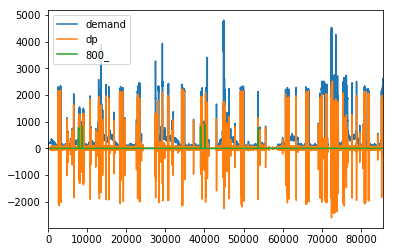

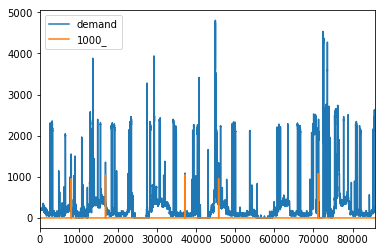

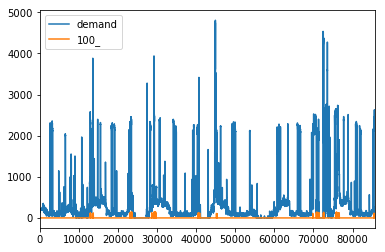

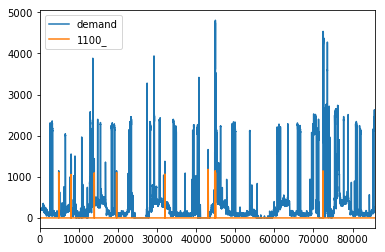

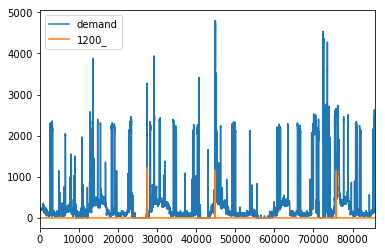

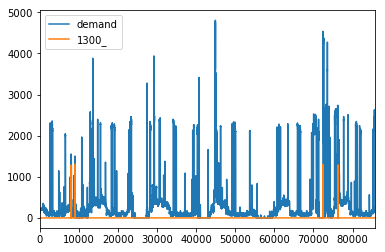

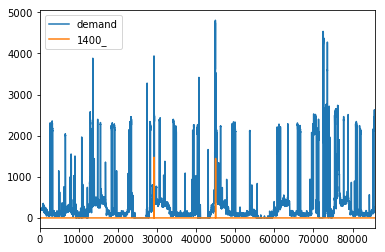

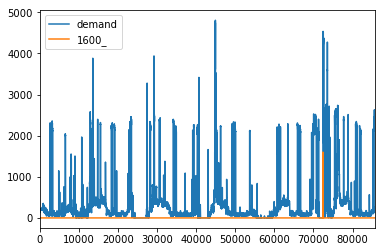

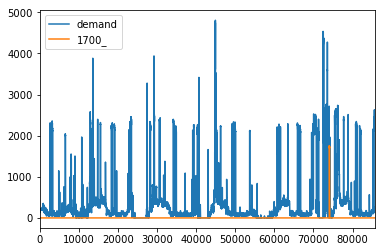

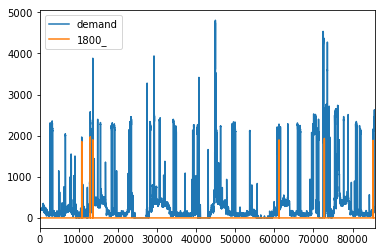

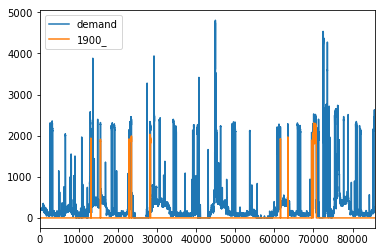

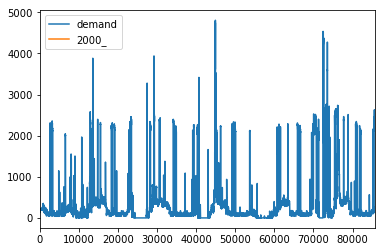

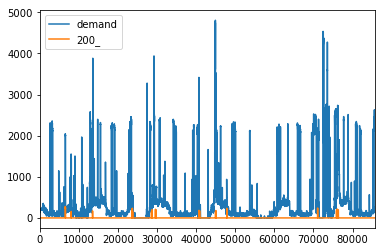

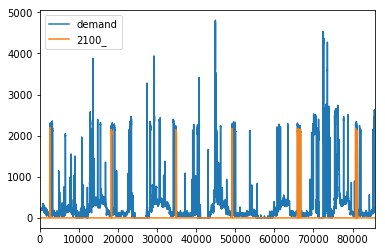

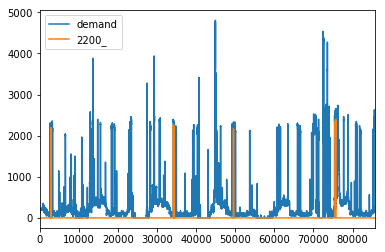

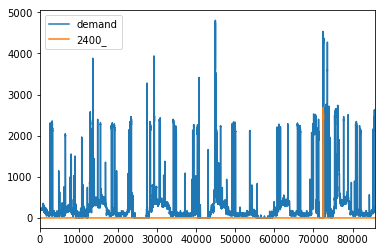

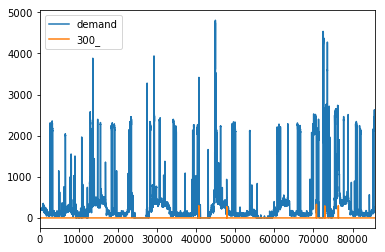

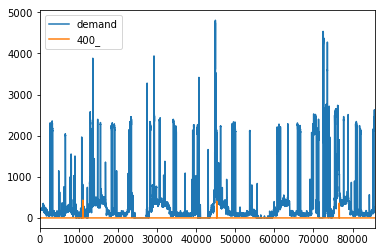

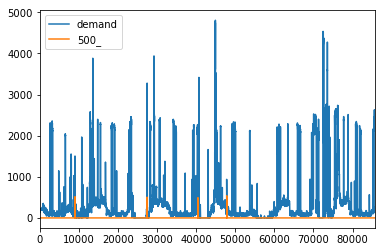

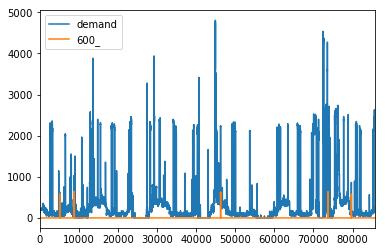

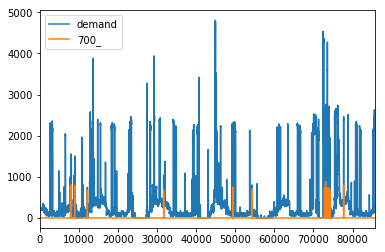

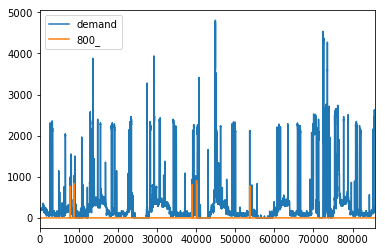

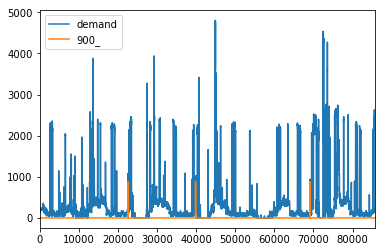

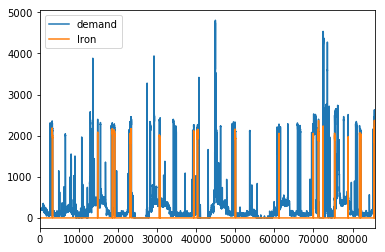

In [72]:
#print(df.loc[7770:7847,['demand','baseload','unknown','800_']])
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df.loc[:,['demand','dp','800_']].plot()
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
    df.loc[:,['demand',i]].plot()


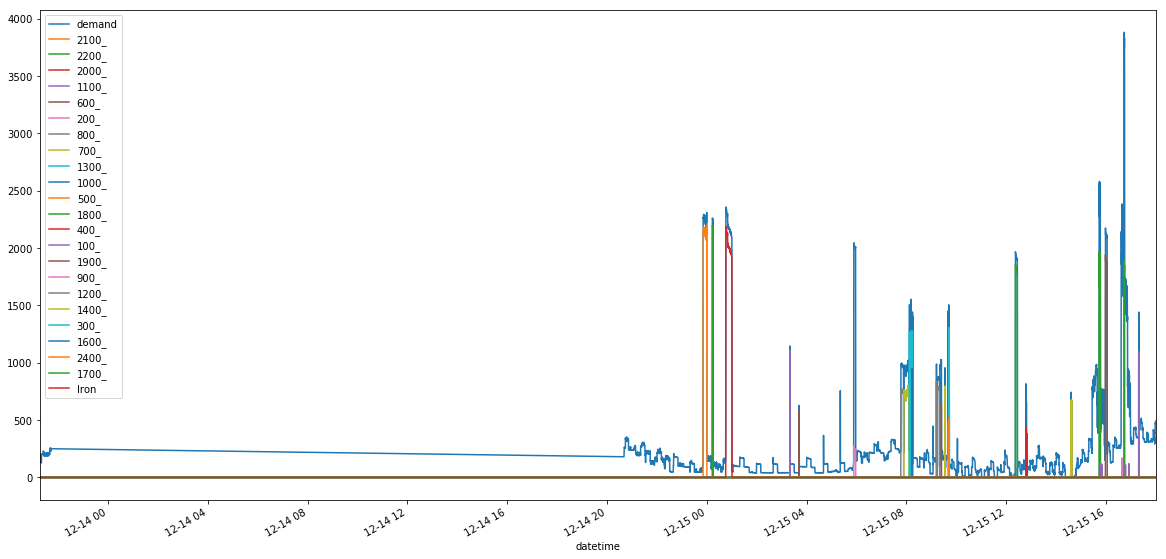

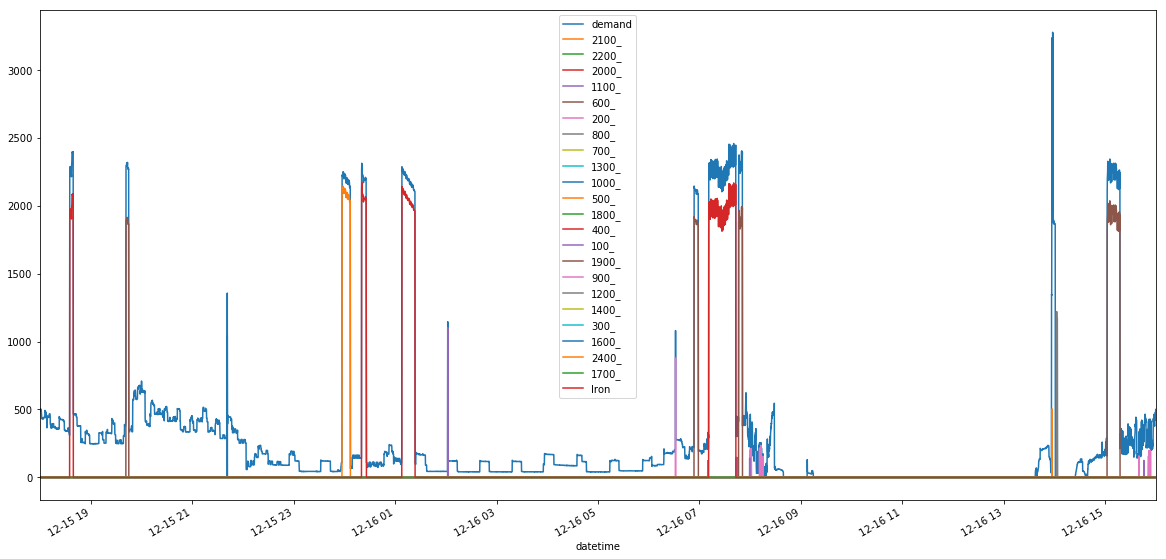

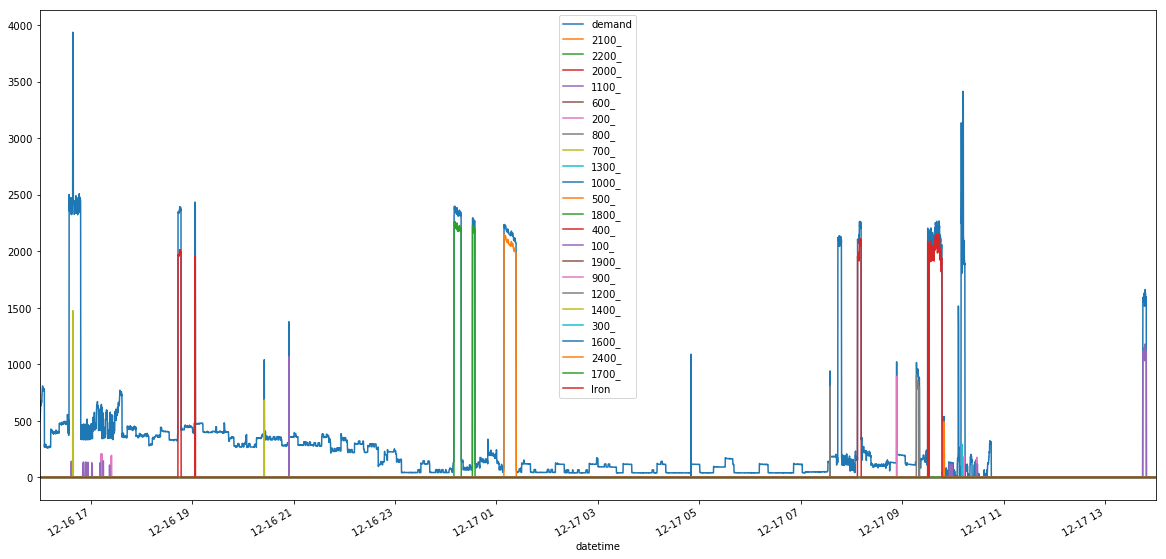

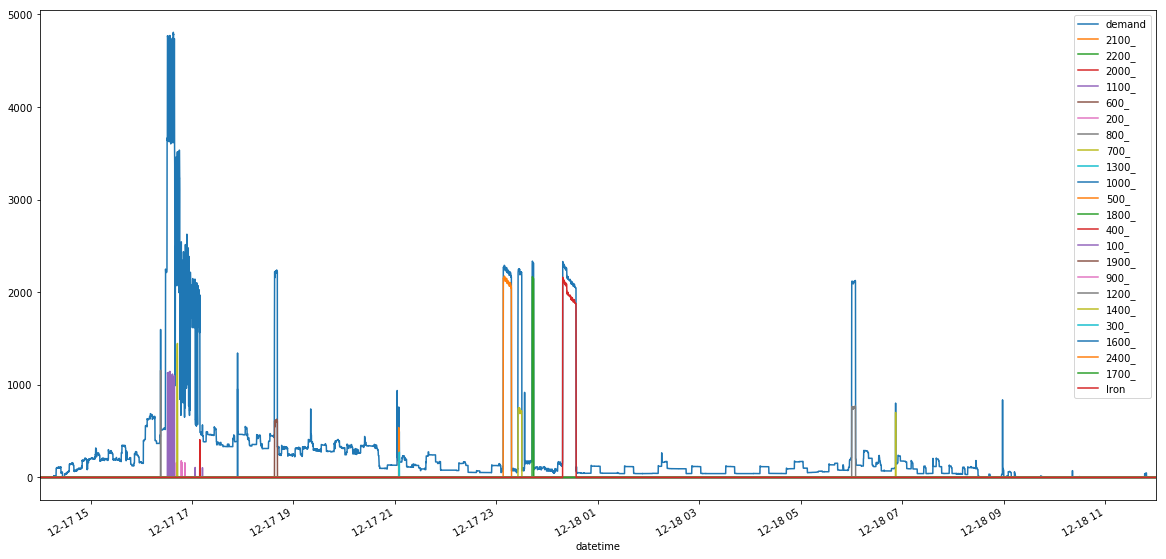

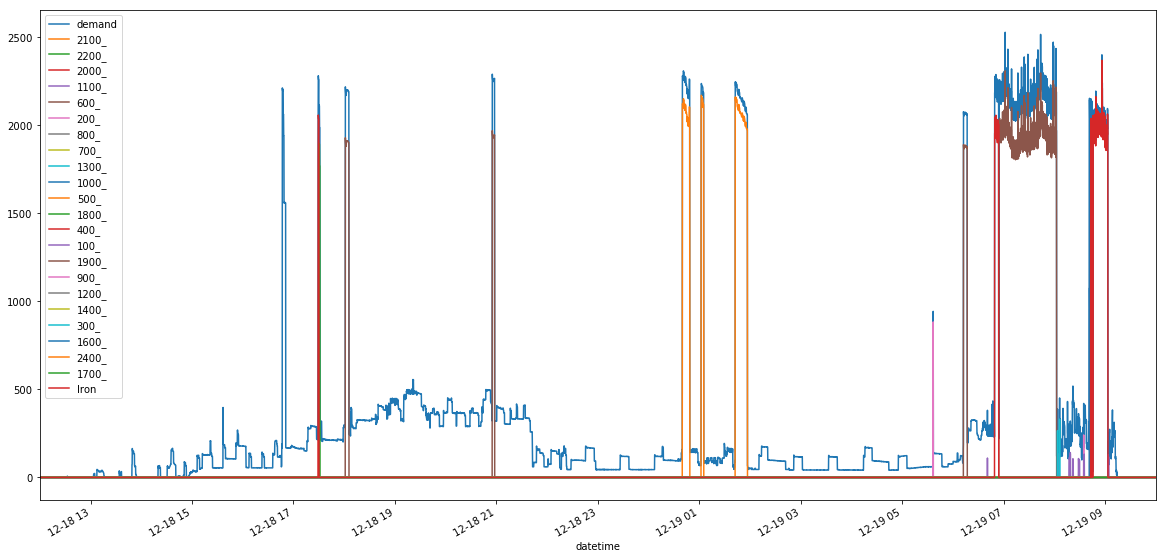

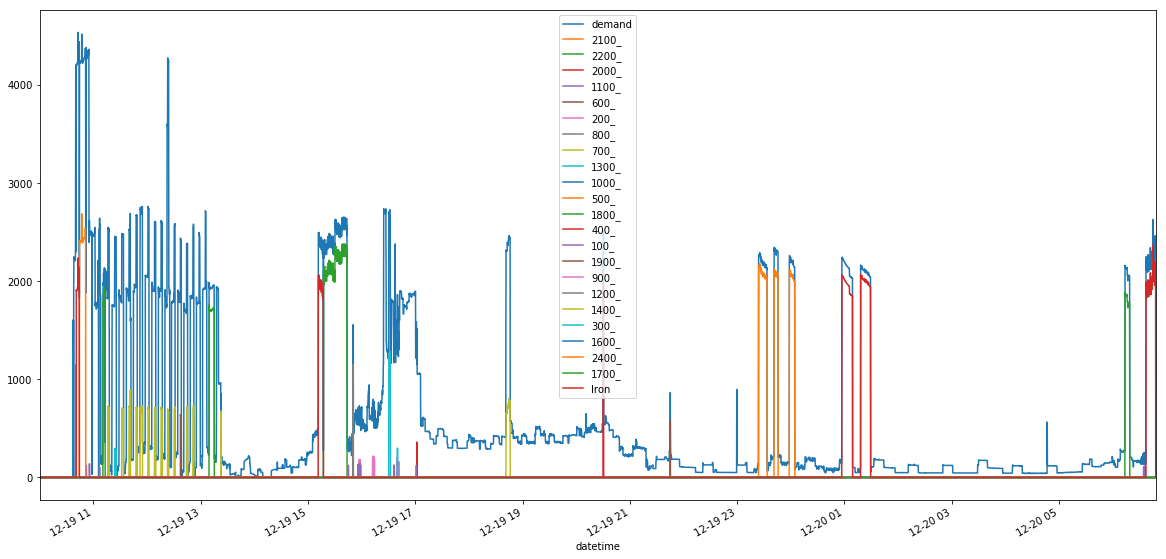

In [106]:
#print(df)
l = list(loads)
l.insert(0, 'datetime')
l.insert(1, 'demand')


step = 600*24 
for i in range(1,len(df),step):
    df.loc[i:i+step,l].plot(x=df.loc[i:i+step,'datetime'],figsize=(20,10))
                            #,kind='area')#,stacked=true)    


In [102]:
print(df.loc[i:i+step,l])

                 datetime  demand  2100_  2200_  2000_  1100_  600_  200_  \
82801 2017-12-20 02:29:57    45.0      0      0    NaN      0     0     0   
82802 2017-12-20 02:30:02    45.0      0      0    NaN      0     0     0   
82803 2017-12-20 02:30:08    45.0      0      0    NaN      0     0     0   
82804 2017-12-20 02:30:13    46.0      0      0    NaN      0     0     0   
82805 2017-12-20 02:30:19    46.0      0      0    NaN      0     0     0   
82806 2017-12-20 02:30:24    49.0      0      0    NaN      0     0     0   
82807 2017-12-20 02:30:30    49.0      0      0    NaN      0     0     0   
82808 2017-12-20 02:30:35    46.0      0      0    NaN      0     0     0   
82809 2017-12-20 02:30:41    46.0      0      0    NaN      0     0     0   
82810 2017-12-20 02:30:46    46.0      0      0    NaN      0     0     0   
82811 2017-12-20 02:30:52    45.0      0      0    NaN      0     0     0   
82812 2017-12-20 02:30:57    45.0      0      0    NaN      0     0     0   

In [54]:
import plotly.offline
import plotly.graph_objs as go
import cufflinks
import plotly.offline as py


# cufflinks.go_offline()

In [65]:
start = 0
points = 1000
try:
    start = plots * points
except:
    plots = 0
# plots = 0

    
res = df.set_index('datetime')
#res[start:start+points].iplot(kind='line')

plots = plots +1
plt = df.loc[7770:7847,['demand','baseload','unknown','800_']]
trace = go.Figure(data=plt, values=plt)
plt.iplot([trace], filename='test.html')

PlotlyDictValueError: 'data' has invalid value inside 'figure'

Path To Error: ['data']

Current path: []
Current parent object_names: []

Additionally:

    role: object



In [107]:
# print(list(loads['100_'][0]))
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
#     for load in loads[i]:
#         if i == '100_':
#             print(round(sum(loads[i][load]['profile'])/360,1),'Wh in ',loads[i][load]['time'])
            


1000_ has 5 occurance(s)
100_ has 55 occurance(s)
1100_ has 13 occurance(s)
1200_ has 4 occurance(s)
1300_ has 7 occurance(s)
1400_ has 2 occurance(s)
1600_ has 1 occurance(s)
1700_ has 1 occurance(s)
1800_ has 6 occurance(s)
1900_ has 9 occurance(s)
2000_ has 23 occurance(s)
200_ has 38 occurance(s)
2100_ has 10 occurance(s)
2200_ has 5 occurance(s)
2400_ has 1 occurance(s)
300_ has 6 occurance(s)
400_ has 4 occurance(s)
500_ has 6 occurance(s)
600_ has 5 occurance(s)
700_ has 21 occurance(s)
800_ has 7 occurance(s)
900_ has 3 occurance(s)
Iron has 23 occurance(s)


In [108]:

res = df.set_index('datetime')
# res[:1000].iplot(kind='line')
# fig = res.plot()
# fig.show()
res.resample('10T').iplot(kind='line')



# res[:100]

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:


.resample() is now a deferred operation
You called iplot(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead



In [109]:

# df[['datetime',list(loads)]].iplot()
temp = list(loads)
temp[0] = 'datetime'
temp[1] = 'baseload'
temp[2] = 'unknown'

temp[3:] =list(loads)
dp = df[temp]
dp = dp.set_index('datetime')
dp.resample('10T').mean().iplot(kind='line')
# dp.resample('10T').mean().iplot(kind='area',fill='tozeroy',mode='none')



KeyError: "['2000_'] not in index"

In [110]:
pie = dp.sum()
# values = pie.values/pie.sum()*100
round(pie/pie.sum()*100,1)


baseload    -4.2
unknown     65.8
2100_        7.2
2200_        3.5
2000_       14.1
1100_        0.4
600_         0.2
200_         0.1
800_         0.6
700_         1.1
1300_        0.2
1000_        0.1
500_         0.0
1800_        1.3
400_         0.0
100_         0.1
1900_        8.3
900_         0.0
1200_        0.0
1400_        0.1
300_         0.0
1600_        0.0
2400_        0.7
1700_        0.4
dtype: float64

In [111]:
trace = go.Pie(labels=pie.index, values=pie.values)
dp.iplot([trace], filename=name)

In [112]:
# import plotly.plotly as py
import plotly.offline as py

trace = go.Pie(labels=pie.index, values=pie.values)

py.plot([trace], filename='disaggregator_results_pie.html')

'file:///Users/arnekaas/Documents/GitHub/disaggregation/disaggregator-deltaPower/disaggregator_results_pie.html'

# Try to rename colums for 'kwown loads' 

In [62]:
#relable output for known_loads
known_loads = {'100_':'Fridge','2000_':'Iron'}
for name in loads.keys():
    try:
        df=df.rename(columns = {name:known_loads[name]})
        loads[known_loads[name]] = loads[name]
    except:
        print(name,'not found known_loads')
    
for name in known_loads:
    try:
        del loads[name]
    except:
        print(name,'not found in legend')

legend = loads.keys()
print(list(legend))

2100_ not found known_loads
2200_ not found known_loads


RuntimeError: dictionary changed size during iteration